<a href="https://colab.research.google.com/github/sggyuan/GNN/blob/main/test_for_simple_model_(_resampling_method%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. data overview**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/subset10w.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   User                         100000 non-null  int64  
 1   Card                         100000 non-null  int64  
 2   Year                         100000 non-null  int64  
 3   Month                        100000 non-null  int64  
 4   Day                          100000 non-null  int64  
 5   Time                         100000 non-null  object 
 6   Amount                       100000 non-null  object 
 7   Use Chip                     100000 non-null  object 
 8   Merchant Name                100000 non-null  int64  
 9   Merchant City                100000 non-null  object 
 10  Merchant State               88723 non-null   object 
 11  Zip                          88095 non-null   float64
 12  MCC                          100000 non-null  int64  
 13  

In [5]:
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,907,3,2018,8,8,22:18,$86.89,Chip Transaction,-5162038175624867091,Houston,...,Houston,TX,77086,29.76,-95.38,$14959,$30495,$70825,773,4
1,1117,2,2010,9,28,08:30,$1.91,Swipe Transaction,6091778774361517457,Vanceboro,...,Vanceboro,NC,28586,35.30,-77.15,$14844,$30265,$36789,814,4
2,545,2,2009,2,23,13:54,$13.82,Swipe Transaction,2027553650310142703,Bradenton,...,Bradenton,FL,34203,27.48,-82.57,$17590,$35868,$48465,562,4
3,478,0,2013,12,10,12:20,$15.34,Swipe Transaction,-4317138273541964845,South Haven,...,Kalamazoo,MI,49048,42.24,-85.48,$17409,$35499,$80517,724,1
4,1953,0,2013,11,30,12:39,$14.82,Swipe Transaction,-5581123930363301609,Newalla,...,Meeker,OK,74855,35.48,-96.89,$17730,$36152,$81345,716,1
5,162,0,2002,9,20,20:51,$69.13,Swipe Transaction,1913477460590765860,Etowah,...,Lansing,NC,28643,36.49,-81.50,$12630,$25748,$41455,738,3
6,1687,1,2012,5,18,06:57,$25.09,Online Transaction,-2088492411650162548,ONLINE,...,Stratford,CT,6614,41.20,-73.13,$27589,$56248,$149587,728,4
7,1449,1,2015,7,7,13:29,$13.08,Chip Transaction,-5162038175624867091,Stanton,...,Stanton,CA,90680,33.79,-117.99,$17564,$35813,$43474,748,2
8,507,0,2010,8,27,17:44,$33.93,Swipe Transaction,-4334232547381218591,Chiefland,...,High Springs,FL,32643,29.82,-82.59,$19693,$40156,$70128,738,3
9,605,1,2010,6,28,07:36,$22.89,Swipe Transaction,8878665205966093747,Calverton,...,Broad Run,VA,20137,38.81,-77.72,$35905,$73208,$115827,664,6


In [6]:
# Check the number of fraudulent transactions
df['Is Fraud?'].value_counts()

,count
Is Fraud?,
No,99883
Yes,117


In [7]:
df [df['Is Fraud?'] == 'Yes'].shape

(117, 33)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Apartment'),
  Text(2, 0, 'Zip'),
  Text(3, 0, 'Merchant State'),
  Text(4, 0, 'Card'),
  Text(5, 0, 'Num Credit Cards'),
  Text(6, 0, 'Merchant Name'),
  Text(7, 0, 'MCC'),
  Text(8, 0, 'Merchant City'),
  Text(9, 0, 'Use Chip'),
  Text(10, 0, 'Person'),
  Text(11, 0, 'Amount'),
  Text(12, 0, 'Time'),
  Text(13, 0, 'Day'),
  Text(14, 0, 'Month'),
  Text(15, 0, 'Year'),
  Text(16, 0, 'User'),
  Text(17, 0, 'Total Debt'),
  Text(18, 0, 'Current Age'),
  Text(19, 0, 'FICO Score'),
  Text(20, 0, 'Retirement Age'),
  Text(21, 0, 'Birth Year'),
  Text(22, 0, 'Birth Month'),
  Text(23, 0, 'Gender'),
  Text(24, 0, 'Address'),
  Text(25, 0, 'City'),
  Text(26, 0, 'State'),
  Text(27, 0, 'Zipcode'),
  Text(28, 0, 'Latitude'),
  Text(29, 0, 'Longitude'),
  Text(30, 0, 'Pe

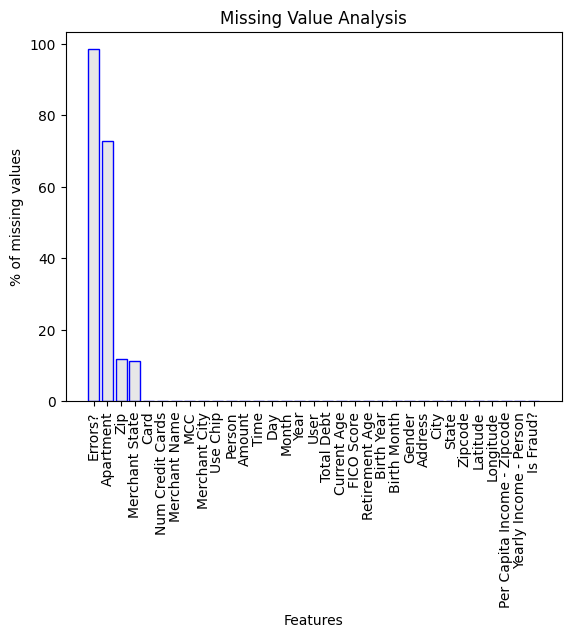

In [8]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

In [9]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [10]:
df.Amount.head(5)

,Amount
0,$86.89
1,$1.91
2,$13.82
3,$15.34
4,$14.82


In [11]:
# We need to strip the '$' from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [12]:
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [13]:
df.Hour

,Hour
0,22
1,08
2,13
3,12
4,12
...,...
99995,07
99996,15
99997,12
99998,12


In [14]:
df.Minute

,Minute
0,18
1,30
2,54
3,20
4,39
...,...
99995,51
99996,45
99997,19
99998,34


In [15]:
df = df.drop(columns=["Merchant State","Zip","Apartment"],axis=1)

In [16]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Bad Expiration,Insufficient Balance',
       'Bad PIN,Insufficient Balance',
       'Insufficient Balance,Technical Glitch'], dtype=object)

In [17]:
df["Errors?"]= df["Errors?"].fillna("No error")

In [19]:
# change the is fraud column to binary
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [20]:
df['Per Capita Income - Zipcode'] = df['Per Capita Income - Zipcode'].str.replace('$', '').astype(float)
df['Yearly Income - Person'] = df['Yearly Income - Person'].str.replace('$', '').astype(float)
df['Total Debt'] = df['Total Debt'].str.replace('$', '').astype(float)

In [21]:
categorical_columns = ['Merchant City', 'Errors?' , 'Person', 'Address', 'City', 'State']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

In [22]:
gender_encoded = pd.get_dummies(df['Gender'], prefix='Gender')


df = pd.concat([df, gender_encoded], axis=1)

df = df.drop(['Gender'], axis=1)

In [23]:
bool_columns = df.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df[col] = df[col].astype(int)

In [24]:
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   User                         100000 non-null  int64  
 1   Card                         100000 non-null  int64  
 2   Year                         100000 non-null  int64  
 3   Month                        100000 non-null  int64  
 4   Day                          100000 non-null  int64  
 5   Time                         100000 non-null  object 
 6   Amount                       100000 non-null  float64
 7   Use Chip                     100000 non-null  int64  
 8   Merchant Name                100000 non-null  int64  
 9   Merchant City                100000 non-null  int64  
 10  MCC                          100000 non-null  int64  
 11  Errors?                      100000 non-null  int64  
 12  Is Fraud?                    100000 non-null  int64  
 13  

# **GNN**

In [26]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')

In [27]:
# Add nodes to the graph for each unique card_id and merchant_name
for _, row in df.iterrows():
    # Add card_id node with its properties
    G.add_node(row['card_id'],
               person=row['Person'],
               current_age=row['Current Age'],
               retirement_age=row['Retirement Age'],
               birth_year=row['Birth Year'],
               birth_month=row['Birth Month'],
               gender_0=row['Gender_Female'],
               gender_1=row['Gender_Male'],
               address=row['Address'],
               city=row['City'],
               state=row['State'],
               zipcode=row['Zipcode'],
               latitude=row['Latitude'],
               longitude=row['Longitude'],
               per_capita_income=row['Per Capita Income - Zipcode'],
               yearly_income=row['Yearly Income - Person'],
               total_debt=row['Total Debt'],
               fico_score=row['FICO Score'],
               num_credit_cards=row['Num Credit Cards'])
     # Add merchant_name node with its properties
    G.add_node(row['Merchant Name'],
               merchant_city=row['Merchant City'],
               mcc=row['MCC'])

In [28]:
# Add edges and properties to the edges
for _, row in df.iterrows():
    G.add_edge(row['card_id'], row['Merchant Name'],
               year=row['Year'],
               month=row['Month'],
               day=row['Day'],
               hour=row['Hour'],
               minute=row['Minute'],
               amount=row['Amount'],
               use_chip=row['Use Chip'],
               errors=row['Errors?'],
               is_fraud=row['Is Fraud?'])

In [29]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 16283
Number of edges: 100000


In [30]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [31]:
adj_matrix.shape

(16283, 16283)

In [36]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")

Node: 907_3, Properties: card_id
Node: 1117_2, Properties: card_id
Node: 545_2, Properties: card_id
Node: 478_0, Properties: card_id
Node: 1953_0, Properties: card_id
Node: 162_0, Properties: card_id
Node: 1687_1, Properties: card_id
Node: 1449_1, Properties: card_id
Node: 507_0, Properties: card_id
Node: 605_1, Properties: card_id


In [44]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

In [48]:
list(edge_list[0][2].values())

[2018, 8, 8, '22', '18', 86.89, 0, 9, 0]

In [70]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.unsqueeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if isinstance(i, tuple) else float(i) for i in edge_values]
    x.append(edge_values)

x = torch.tensor(x, dtype=torch.float)

In [51]:
# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs=201

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [53]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

In [54]:
# Train the model
for i in range(num_epochs):
    # Forward pass
    output = model(x)
    # Compute the loss
    loss = criterion(output, target)
    if i % 20 == 0:
        print(f'Epoch: {i}, Loss: {loss.item()}')
    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()

Epoch: 0, Loss: 300.080810546875
Epoch: 20, Loss: 0.5337333083152771
Epoch: 40, Loss: 0.6694856286048889
Epoch: 60, Loss: 0.6805036664009094
Epoch: 80, Loss: 0.6705831289291382
Epoch: 100, Loss: 0.6563121676445007
Epoch: 120, Loss: 0.6403424143791199
Epoch: 140, Loss: 0.6232150197029114
Epoch: 160, Loss: 0.6051456928253174
Epoch: 180, Loss: 0.586285412311554
Epoch: 200, Loss: 0.566760241985321


In [57]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import f1_score

In [60]:
# 训练模型
for i in range(num_epochs):
    # 前向传播
    output = model(x)
    # 计算损失
    loss = criterion(output, target)

    if i % 20 == 0:
        # 计算 AUC 和 AP
        with torch.no_grad():
            output_prob = torch.sigmoid(output)
            auc = roc_auc_score(target.cpu().numpy(), output_prob.cpu().numpy())
            ap = average_precision_score(target.cpu().numpy(), output_prob.cpu().numpy())
            f1 = f1_score(target.cpu().numpy(), (output_prob > 0.5).cpu().numpy())
            auroc = roc_auc_score(target.cpu().numpy(), output_prob.cpu().numpy())
        print(f'Epoch: {i}, Loss: {loss.item()}, AUC: {auc}, AP: {ap}, F1: {f1}, AUROC: {auroc}')

    # 梯度归零
    optimizer.zero_grad()
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()

Epoch: 0, Loss: 0.0499044768512249, AUC: 0.4954769730156934, AP: 0.0011641328468825632, F1: 0.0, AUROC: 0.4954769730156934
Epoch: 20, Loss: 0.035791102796792984, AUC: 0.4950136959387783, AP: 0.001146950335864896, F1: 0.0, AUROC: 0.4950136959387783
Epoch: 40, Loss: 0.021634316071867943, AUC: 0.494544043881769, AP: 0.0011283698790969857, F1: 0.0, AUROC: 0.494544043881769
Epoch: 60, Loss: 0.010188007727265358, AUC: 0.49433995894855104, AP: 0.0011166824662758319, F1: 0.0, AUROC: 0.49433995894855104
Epoch: 80, Loss: 0.009905608370900154, AUC: 0.4944787110320784, AP: 0.0011339505099262697, F1: 0.0, AUROC: 0.4944787110320784
Epoch: 100, Loss: 0.009745468385517597, AUC: 0.4932762357599417, AP: 0.0011527718530970326, F1: 0.0, AUROC: 0.4932762357599417
Epoch: 120, Loss: 0.009551087394356728, AUC: 0.48852918598520956, AP: 0.0010947360608928004, F1: 0.0, AUROC: 0.48852918598520956
Epoch: 140, Loss: 0.009411747567355633, AUC: 0.4883372520207617, AP: 0.0011012870024908596, F1: 0.0, AUROC: 0.48833725

In [83]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 假设 y 是您的标签
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

NameError: name 'y' is not defined

In [61]:
pip install imbalanced-learn

In [75]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import torch
from sklearn.model_selection import train_test_split

# 假设 x 是您的特征，target 是您的标签
x_np = x.cpu().numpy()
target_np = target.cpu().numpy()

smote_enn = SMOTEENN(random_state=42)
X_resampled_smote_enn, y_resampled_smote_enn = smote_enn.fit_resample(x_np, target_np)


# 选择一种重采样方法（这里以SMOTE为例）
X_resampled, y_resampled = X_resampled_smote_enn, y_resampled_smote_enn

# 将重采样后的数据转回PyTorch张量
x_resampled = torch.tensor(X_resampled, dtype=torch.float32)
target_resampled = torch.tensor(y_resampled, dtype=torch.float32)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x_resampled, target_resampled, test_size=0.2, random_state=42, stratify=target_resampled)

# 打印重采样前后的类别分布
print("原始数据集类别分布：", np.bincount(target_np.astype(int)))
print("重采样后数据集类别分布：", np.bincount(y_resampled.astype(int)))

原始数据集类别分布： [99883   117]
重采样后数据集类别分布： [96408 99881]


In [76]:
# 更新您的数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 更新您的模型训练循环
model = FraudGNN(input_dim=X_train.shape[1], hidden_dim=16)  # 更新input_dim
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [82]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_output = model(X_test).squeeze()  # 移除所有大小为1的维度
            test_loss = criterion(test_output, y_test.squeeze())
            test_auc = roc_auc_score(y_test.squeeze().numpy(), torch.sigmoid(test_output).numpy())
            print(f"Epoch {epoch}, Test Loss: {test_loss.item():.4f}, Test AUC: {test_auc:.4f}")

# 最终评估
model.eval()
with torch.no_grad():
    final_output = model(X_test)
    final_probs = torch.sigmoid(final_output).numpy()
    final_auc = roc_auc_score(y_test.numpy(), final_probs)
    final_ap = average_precision_score(y_test.numpy(), final_probs)
    print(f"Final Test AUC: {final_auc:.4f}, AP: {final_ap:.4f}")

Epoch 0, Test Loss: 0.6834, Test AUC: 0.5736
Epoch 10, Test Loss: 0.6815, Test AUC: 0.5302
Epoch 20, Test Loss: 0.6776, Test AUC: 0.5241
Epoch 30, Test Loss: 0.7274, Test AUC: 0.5299
Epoch 40, Test Loss: 0.6716, Test AUC: 0.5316
Epoch 50, Test Loss: 0.6707, Test AUC: 0.5327
Epoch 60, Test Loss: 0.6681, Test AUC: 0.5361
Epoch 70, Test Loss: 0.6738, Test AUC: 0.5334
Epoch 80, Test Loss: 0.6706, Test AUC: 0.5327
Epoch 90, Test Loss: 0.6834, Test AUC: 0.5147


ValueError: Found array with dim 3. None expected <= 2.